In [2]:
import heapq
import matplotlib.pyplot as plt
import numpy as np

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs
    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [8]:
import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)

class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
        schedule = Schedule()
        bus_system = BusSystem(arrival_rate, service_rate)
        bus_system.run(schedule)
        while schedule.next_event_time() < run_until:
            schedule.run_next_event()
        return bus_system

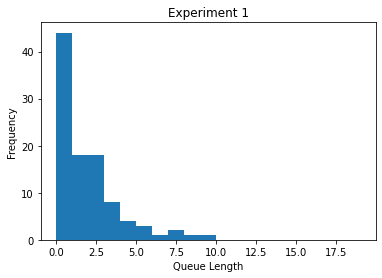

Sample mean: 1.46
95% confidence interval of population mean: [1.8372913222142562, 1.0827086777857438]


In [13]:
def trial_run(trials, arrival_rate, service_rate):
    experiment = []
    for i in range(trials):
        bus_system = run_simulation(arrival_rate, service_rate, run_until=100)
        queue = bus_system.queue.people_in_queue
        experiment.append(bus_system.queue.people_in_queue)
    return experiment

first_experiment = trial_run(100, 0.8, 1)


plt.figure()
plt.hist(first_experiment, range(0,20))
plt.title('Experiment 1')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

mean = np.mean(first_experiment)
t_val = sts.sem(first_experiment)

print('Sample mean:', mean)
print('95% confidence interval of population mean:', [mean + 1.96*t_val, mean - 1.96*t_val])

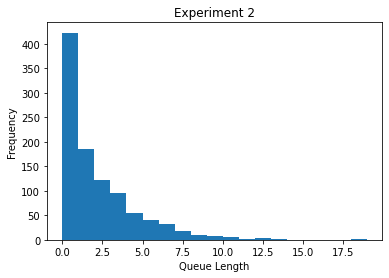

Sample mean: 1.737
95% confidence interval of population mean: [1.8808327035698635, 1.5931672964301367]


In [15]:
second_experiment = trial_run(1000, 0.8, 1)
plt.figure()
plt.hist(second_experiment, range(0,20))
plt.title('Experiment 2')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

mean = np.mean(second_experiment)
t_val = sts.sem(second_experiment)

print('Sample mean:', mean)
print('95% confidence interval of population mean:', [mean + 1.96*t_val, mean - 1.96*t_val])

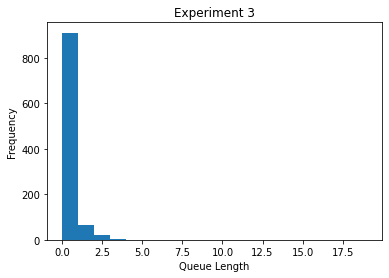

Sample mean: 0.123
95% confidence interval of population mean: [0.14987838688019206, 0.09612161311980794]


In [16]:
third_experiment = trial_run(1000, 0.4, 1)
plt.figure()
plt.hist(third_experiment, range(0,20))
plt.title('Experiment 3')
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

mean = np.mean(third_experiment)
t_val = sts.sem(third_experiment)

print('Sample mean:', mean)
print('95% confidence interval of population mean:', [mean + 1.96*t_val, mean - 1.96*t_val])

Both #EmpiricalAnalyses and #Professionalism were applied throughout this exercise. I think that this exercise was geared towards me understanding the model evaluation techniques and process. For this purpose,it was pertinent to experiment with the different levers of the model itself. By changing the number of people entering the system, the behavior of the system was better understood since it started converging with lesser attribution to random choice. Secondly, changing the arrival late determined how many blockages would be formed overall within the scenario. Service time was also linked with this and both of these combined to portray the long term behavior of the distribution and the system.